# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/LSTM_ED/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/LSTM_ED/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/LSTM_ED/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/LSTM_ED/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Loading features from file.
Loading features from file.
Loading features from file.
Loading features from file.
--- 2.4539835453033447 seconds ---


In [6]:
def find_collisions_zones(collisions):
    ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
    ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()
    d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
    collision_zones = pd.DataFrame(d)
    return collision_zones

In [7]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [8]:
def get_train_test_data(df_features, df_features_collision, full_normal=True):
    df_features.isnull().values.any()
    #df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
    df_features_nonan = df_features.fillna(0)
    df_features_collision_nonan = df_features_collision.fillna(0)

    # I normally want to train on the whole normal dataset
    if not full_normal:
        df_train, df_test = train_test_split(df_features_nonan)
    else:
        df_train = df_features_nonan
        df_test = df_features_collision_nonan
        
    X_train = df_train.drop(["label", "start", "end"], axis=1)
    y_train = df_train["label"]
    X_test = df_test.drop(["label", "start", "end"], axis=1)
    y_test = df_test["label"]

    # Normalize features
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

    # Remove zero-variance features
    selector_variance = VarianceThreshold()
    selector_variance.fit(X_train)
    X_train = pd.DataFrame(selector_variance.transform(X_train),
                            columns=X_train.columns.values[selector_variance.get_support()])

    # Remove highly correlated features
    corr_features = tsfel.correlated_features(X_train,
                                            threshold=0.95)
    X_train.drop(corr_features, inplace=True, axis=1)

    # Lasso selector
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    lasso = SelectFromModel(lsvc, prefit=True)
    selected_features = X_train.columns.values[lasso.get_support()]
    X_train = X_train[selected_features].copy()

    # Labels
    num_classes = len(set(y_train))
    y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Test
    X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                        columns=X_test.columns.values[selector_variance.get_support()])
    X_test.drop(corr_features, inplace=True, axis=1)
    X_test = X_test[selected_features].copy()

    num_classes = len(y_train_categorical[0])
    
    return X_train, y_train, X_test, y_test, df_test

In [9]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


In [10]:
X_test_start_end

machine_nameKuka Robot_apparent_power-_Absolute energy  \
0                                        2.731075e+06        
1                                        2.723880e+06        
2                                        3.459220e+06        
3                                        3.187829e+06        
4                                        2.701860e+06        
..                                                ...        
0                                        5.315409e+06        
0                                        6.450404e+06        
0                                        6.526286e+06        
0                                        5.959610e+06        
0                                        6.358988e+06        

    machine_nameKuka Robot_apparent_power-_Average power  \
0                                       275866.130066      
1                                       275139.441030      
2                                       349416.128563      
3                                       322002.924872      
4                                       272915.191702      
..                                                ...      
0                                       450458.429206      
0                                       464057.849774      
0                                       438005.781007      
0                                       428748.903981      
0                                       426777.720435      

    machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0  \
0                                                20.0                
1                                                20.0                
2                                                20.0                
3                                                20.0                
4                                                20.0                
..                                                ...                
0                                                23.0                
0                                                28.0                
0                                                30.0                
0                                                28.0                
0                                                30.0                

    machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1  \
0                                                80.0                
1                                                80.0                
2                                                80.0                
3                                                80.0                
4                                                80.0                
..                                                ...                
0                                                95.0                
0                                               112.0                
0                                               120.0                
0                                               112.0                
0                                               120.0                

    machine_nameKuka Robot_apparent_power-_ECDF Percentile_0  \
0                                          164.857727          
1                                          164.642792          
2                                          164.884689          
3                                          164.178711          
4                                          164.019394          
..                                                ...          
0                                          185.552048          
0                                          190.422638          
0                                          172.659821          
0                                          191.457367          
0                                          167.306030          

    machine_nameKuka Robot_apparent_power-_ECDF Percentile_1  \
0                      

In [11]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [12]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [13]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [14]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)


## LSTM-ED

In [15]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=50,
    batch_size=64,
    lr=1e-3,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.30,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 50/50 [01:23<00:00,  1.68s/it]
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


LSTM-ED training completed.


In [16]:
y_test_predict = classifier.predict(X_test)

In [17]:
len(y_test_predict)

306

In [18]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [19]:
len(anomaly_scores), len(anomaly_scores1), len(anomaly_scores5)

(306, 164, 141)

In [20]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 10 with threshold 848.7337935902192, std
Number of anomalies detected: 120 with threshold 120.49979329068182, mad
Number of anomalies detected: 16 with threshold 652.3316575478846, percentile
Number of anomalies detected: 7 with threshold 951.0345990050816, IQR

Number of anomalies detected: 8 with threshold 578.6251009699746, std
Number of anomalies detected: 47 with threshold 107.98897301452254, mad
Number of anomalies detected: 9 with threshold 560.9251045486457, percentile
Number of anomalies detected: 16 with threshold 252.06606346509324, IQR

Number of anomalies detected: 3 with threshold 1017.0098094394746, std
Number of anomalies detected: 38 with threshold 506.6906244612182, mad
Number of anomalies detected: 8 with threshold 680.0653164482007, percentile
Number of anomalies detected: 3 with threshold 1174.8606874113725, IQR



In [21]:
y_collisions_predict = anomaly_scores > thresholds[1]
y_collisions_predict1 = anomaly_scores1 > thresholds_1[1]
y_collisions_predict5 = anomaly_scores5 > thresholds_5[1]

### Anomaly Detection

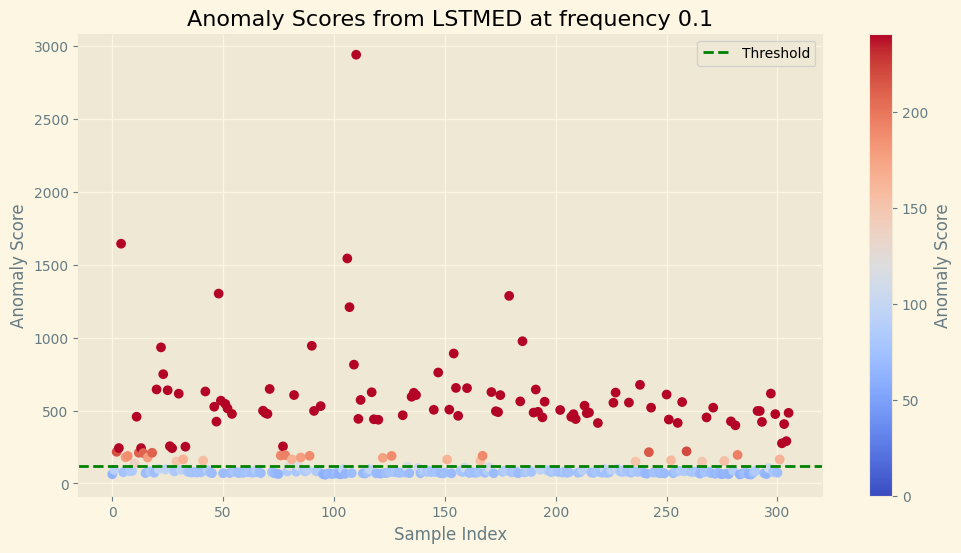

Number of anomalies detected: 120


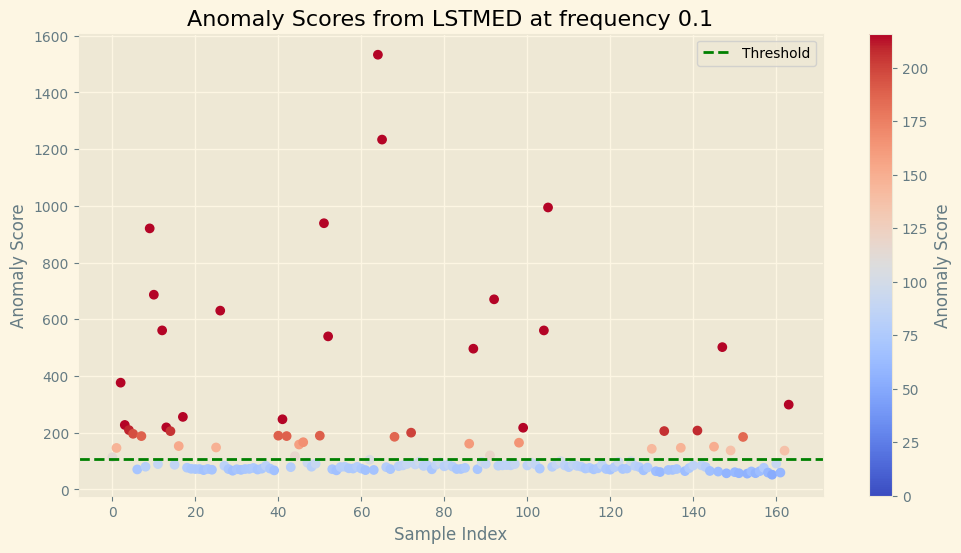

Number of anomalies detected: 47


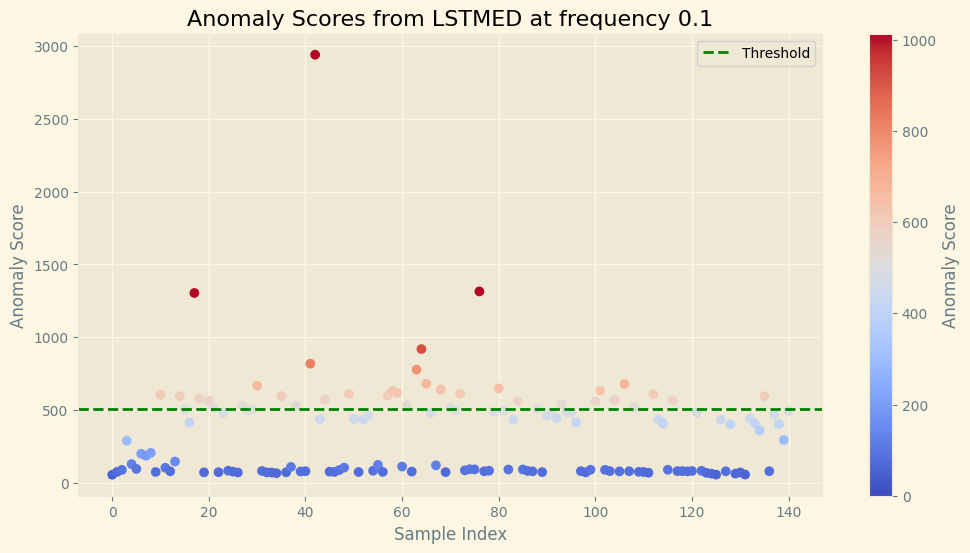

Number of anomalies detected: 38


In [22]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [23]:
X_test_start_end['anomaly_scores'] = anomaly_scores
X_test_start_end['is_collision'] = y_collisions_predict
X_test_start_end1['anomaly_scores'] = anomaly_scores1
X_test_start_end1['is_collision'] = y_collisions_predict1
X_test_start_end5['anomaly_scores'] = anomaly_scores5
X_test_start_end5['is_collision'] = y_collisions_predict5

In [24]:
def compute_metrics(anomaly_scores, y_test, threshold):
    
    print(f"Threshold: {threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(y_test, anomaly_scores > threshold)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, anomaly_scores > threshold)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision
    precision = precision_score(y_test, anomaly_scores > threshold)
    print(f"Precision: {precision:.4f}")
    
    # Calculate recall
    recall = recall_score(y_test, anomaly_scores > threshold)
    print(f"Recall: {recall:.4f}")
    
    print(classification_report(y_test, anomaly_scores > threshold))

In [25]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

Threshold: 120.4998
ROC AUC Score: 0.9873
F1 Score: 0.9333
Accuracy: 0.9510
Precision: 0.8750
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       201
           1       0.88      1.00      0.93       105

    accuracy                           0.95       306
   macro avg       0.94      0.96      0.95       306
weighted avg       0.96      0.95      0.95       306

############################################
Threshold: 107.9890
ROC AUC Score: 0.9823
F1 Score: 0.8537
Accuracy: 0.9268
Precision: 0.7447
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       129
           1       0.74      1.00      0.85        35

    accuracy                           0.93       164
   macro avg       0.87      0.95      0.90       164
weighted avg       0.95      0.93      0.93       164

############################################
Threshold: 506.6906
ROC AUC Score: 0.9

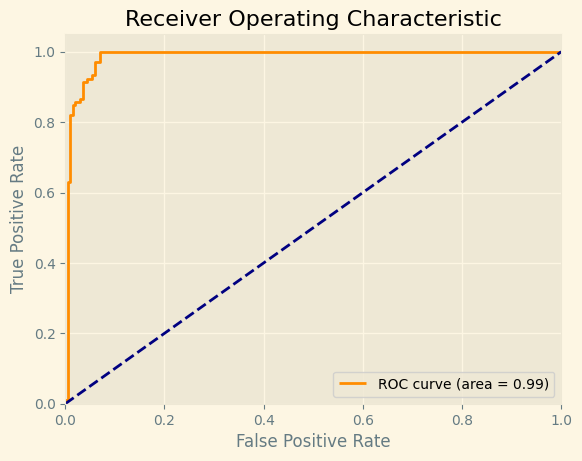

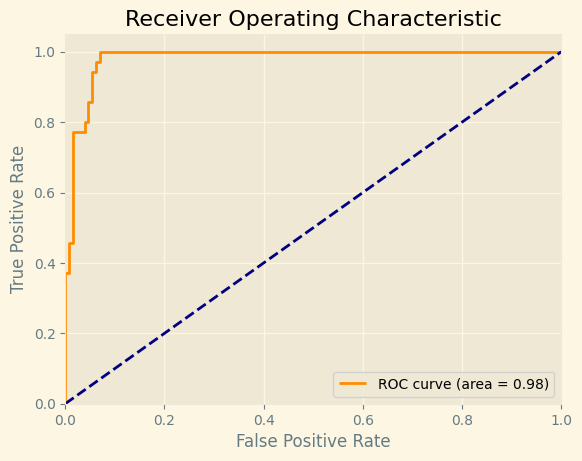

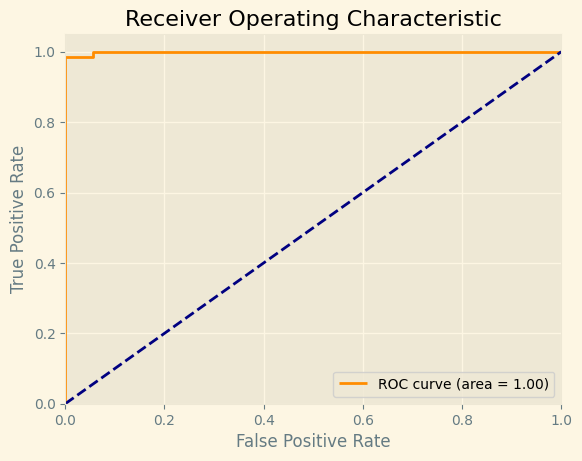

In [26]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [27]:
def convert_to_df(collisions_zones):
    collisions_zones_df = pd.DataFrame(collisions_zones)
    # change the type of the columns to datetime
    collisions_zones_df['start'] = pd.to_datetime(collisions_zones_df['start'])
    collisions_zones_df['end'] = pd.to_datetime(collisions_zones_df['end'])
    
    return collisions_zones_df

In [28]:
collisions_zones_df = convert_to_df(collisions_zones)
collisions_zones_df_1 = convert_to_df(collisions_zones_1)
collisions_zones_df_5 = convert_to_df(collisions_zones_5)

In [29]:
X_test_start_end

machine_nameKuka Robot_apparent_power-_Absolute energy  \
0                                        2.731075e+06        
1                                        2.723880e+06        
2                                        3.459220e+06        
3                                        3.187829e+06        
4                                        2.701860e+06        
..                                                ...        
0                                        5.315409e+06        
0                                        6.450404e+06        
0                                        6.526286e+06        
0                                        5.959610e+06        
0                                        6.358988e+06        

    machine_nameKuka Robot_apparent_power-_Average power  \
0                                       275866.130066      
1                                       275139.441030      
2                                       349416.128563      
3                                       322002.924872      
4                                       272915.191702      
..                                                ...      
0                                       450458.429206      
0                                       464057.849774      
0                                       438005.781007      
0                                       428748.903981      
0                                       426777.720435      

    machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0  \
0                                                20.0                
1                                                20.0                
2                                                20.0                
3                                                20.0                
4                                                20.0                
..                                                ...                
0                                                23.0                
0                                                28.0                
0                                                30.0                
0                                                28.0                
0                                                30.0                

    machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1  \
0                                                80.0                
1                                                80.0                
2                                                80.0                
3                                                80.0                
4                                                80.0                
..                                                ...                
0                                                95.0                
0                                               112.0                
0                                               120.0                
0                                               112.0                
0                                               120.0                

    machine_nameKuka Robot_apparent_power-_ECDF Percentile_0  \
0                                          164.857727          
1                                          164.642792          
2                                          164.884689          
3                                          164.178711          
4                                          164.019394          
..                                                ...          
0                                          185.552048          
0                                          190.422638          
0                                          172.659821          
0                                          191.457367          
0                                          167.306030          

    machine_nameKuka Robot_apparent_power-_ECDF Percentile_1  \
0                      

In [49]:
def plot_signals(df, df_action, collisions_zones, df_predicted_zones, title="Some signals", saveplot=False):
    fig = go.Figure()
    signals = [
    # "sensor_id1_AngY",
    # "sensor_id2_AngX",
    # "sensor_id5_AngY",
    # "sensor_id4_AccZ",
    # "sensor_id4_AngX",
    # "machine_nameKuka Robot_power"
    ]

    # signals = df.columns
    
    start = df.index[0]
    df_reduced = df.loc[start:]
    duration = 3600 * 3  # seconds
    time_delta = df_reduced.index - start
    df_interval = df_reduced[time_delta.total_seconds() <= duration]
    j = 0

    # Leveraging plotly express
    n_colors = len(signals)
    colors = px.colors.sample_colorscale("greys", [n/(n_colors -1) for n in range(n_colors)])  # From continuous colormap
    colors = px.colors.qualitative.Set2  # From discrete colormap, see https://plotly.com/python/discrete-color/
    df_signals = df_interval[signals].select_dtypes(['number'])
    df_signals = df_signals / df_signals.max()
    fig = px.line(df_signals, x=df_signals.index, y=df_signals.columns, color_discrete_sequence=colors)

    # Leveraging plotly graph object
    colors_action = px.colors.qualitative.Antique
    j = 0
    for action in df_action.loc[df_interval.index].action.unique():
        df_action_interval = df_action.loc[df_interval.index]
        df_action_single_action = df_action_interval[df_action_interval['action'] == action]
        fig.add_trace(go.Scatter(
            x=df_action_single_action.index,
            y=[-0.3] * len(df_action_single_action.index),
            line_shape="hv",
            line=dict(color=colors_action[j % len(colors_action)], width=2.5),
            name=action))
        j += 1

    # Highlight collision zones
    for _, row in collisions_zones.iterrows():
        fig.add_vrect(
            x0=row['start'], x1=row['end'],
            fillcolor="blue", opacity=0.3,
            layer="below", line_width=0,
        )
    
    # Highlight predicted collision zones
    for _, row in df_predicted_zones.iterrows():
        if row['is_collision'] == 1:
            fig.add_vrect(
                x0=row['start'], x1=row['end'],
                fillcolor="red", opacity=0.3,
                layer="below", line_width=0,
            )

    fig.update_layout(
    title=title,
    xaxis_title="Time",
    yaxis_title="",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Black"
    )
    )
    fig.show()
    
    if saveplot:
        fig.write_html(f"../plots/{title}.html")
        #fig.write_image(f"../plots/{title}.png")
        print(f"Plot saved in ../plots/{title}.html and ../plots/{title}.png")

In [50]:
plot_signals(df_collision, df_action_collision, collisions_zones_df, X_test_start_end, title="Normal data with predicted collisions", saveplot=False)

In [51]:
plot_signals(df_collision_1, df_action_collision_1, collisions_zones_df_1, X_test_start_end1, title="Collision 1 data with predicted collisions", saveplot=False)

In [52]:
plot_signals(df_collision_5, df_action_collision_5, collisions_zones_df_5, X_test_start_end5, title="Collision 5 data with predicted collisions", saveplot=False)